In [322]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import feature_selection, linear_model
import statsmodels.formula.api as smf
from sklearn import metrics

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

<font size="7"><strong>
&#128564;&nbsp;&nbsp;
Same DF</strong></font> 

In [283]:
df = pd.read_csv('train.csv')

In [284]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [285]:
df.columns 


Index([u'Store', u'Dept', u'Date', u'Weekly_Sales', u'IsHoliday'], dtype='object')

<font size="5"><strong>Adding more columns again....</strong></font> 

In [286]:
df.Date

0         2010-02-05
1         2010-02-12
2         2010-02-19
3         2010-02-26
4         2010-03-05
             ...    
421565    2012-09-28
421566    2012-10-05
421567    2012-10-12
421568    2012-10-19
421569    2012-10-26
Name: Date, dtype: object

In [287]:
df.Date = pd.to_datetime(df.Date)

In [288]:
df.set_index('Date', inplace = True)

df['Year'] = df.index.year
df['Month'] = df.index.month

In [289]:
df

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month
Date,,,,,,
2010-02-05,1,1,24924.50,False,2010,2
2010-02-12,1,1,46039.49,True,2010,2
2010-02-19,1,1,41595.55,False,2010,2
2010-02-26,1,1,19403.54,False,2010,2
2010-03-05,1,1,21827.90,False,2010,3
...,...,...,...,...,...,...
2012-09-28,45,98,508.37,False,2012,9
2012-10-05,45,98,628.10,False,2012,10
2012-10-12,45,98,1061.02,False,2012,10


<strong>Now we have added both 'Year' and 'Month' to the data frame.</strong> 

<strong>Now, let's transform 'IsHoliday' from a boolean to a dummy variable</strong>

In [290]:
df['IsHoliday'] = 1 * df['IsHoliday']

In [291]:
df

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month
Date,,,,,,
2010-02-05,1,1,24924.50,0,2010,2
2010-02-12,1,1,46039.49,1,2010,2
2010-02-19,1,1,41595.55,0,2010,2
2010-02-26,1,1,19403.54,0,2010,2
2010-03-05,1,1,21827.90,0,2010,3
...,...,...,...,...,...,...
2012-09-28,45,98,508.37,0,2012,9
2012-10-05,45,98,628.10,0,2012,10
2012-10-12,45,98,1061.02,0,2012,10


<ul><li><strong>To increase our chances of building a more accurate model, lets add even more features:</strong><ul>
<li><strong>Let's create categories for high sales and low sales.</strong></li>
<li><strong>All Weekly Sales that are below the mean of the data will be classified as "Low".</strong.</li>
<li><strong>All Weekly Sales that are above the mean of the data will be classified as "High".</strong></li></ul> 

In [292]:
df.Weekly_Sales < 15981.258123467243 

Date
2010-02-05    False
2010-02-12    False
2010-02-19    False
2010-02-26    False
2010-03-05    False
              ...  
2012-09-28     True
2012-10-05     True
2012-10-12     True
2012-10-19     True
2012-10-26     True
Name: Weekly_Sales, dtype: bool

In [293]:
mask = (df['Weekly_Sales'] > df['Weekly_Sales'].median())

df['SalesCategory'] = 'Low'
df.loc[mask, 'SalesCategory'] = 'High'


<strong>Let's make sure to transform the Sales Catecorgy (High or Low) into dummy variables.</strong> 

In [294]:
df['SalesBinary'] = df.SalesCategory.map({'Low' : 0, 'High' : 1})

In [295]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,SalesCategory,SalesBinary
Date,,,,,,,,
2010-02-05,1,1,24924.50,0,2010,2,High,1
2010-02-12,1,1,46039.49,1,2010,2,High,1
2010-02-19,1,1,41595.55,0,2010,2,High,1
2010-02-26,1,1,19403.54,0,2010,2,High,1
2010-03-05,1,1,21827.90,0,2010,3,High,1


<strong>Any correlations?</strong> 

In [296]:
df.corr()

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,SalesBinary
Store,1.000000,0.024004,-0.085195,-0.000548,0.002997,0.001011,-0.066222
Dept,0.024004,1.000000,0.148032,0.000916,0.003738,0.000904,0.020854
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,-0.010111,0.028409,0.589321
IsHoliday,-0.000548,0.000916,0.012774,1.000000,-0.056746,0.123376,0.005223
Year,0.002997,0.003738,-0.010111,-0.056746,1.000000,-0.194288,-0.015691
Month,0.001011,0.000904,0.028409,0.123376,-0.194288,1.000000,0.018018
SalesBinary,-0.066222,0.020854,0.589321,0.005223,-0.015691,0.018018,1.000000


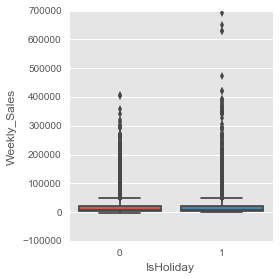

In [297]:
sb.factorplot(x = 'IsHoliday',
    y = 'Weekly_Sales',
    data = df,
    kind = 'box')

<strong>More outliers exist within the IsHoliday category, but otherwise not very promising...</strong>  

<strong><font size="7">Plotting Sales Per Year:</font><strong>

<strong><font size="4">2010</font> (Holidays excluded)</strong>

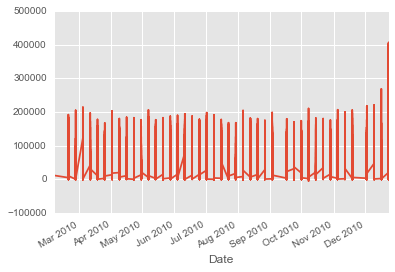

In [298]:
df[(df.IsHoliday == 0)&(df.Year == 2010)].Weekly_Sales.plot()

<strong>Weekly sales for 2010 when there are holidays:</strong> 

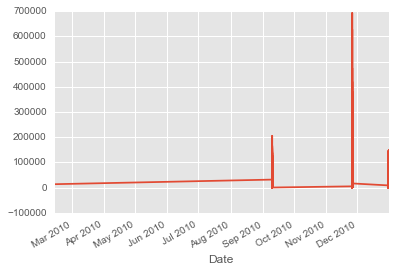

In [299]:
df[(df.IsHoliday == 1) & (df.Year == 2010)].Weekly_Sales.plot()

<strong>It does not appear that sales promotions or holiday excitement affects Labor Day sales.The graph above shows that sales average 20,000 for non holiday times, and the month of September does not exceed that. As expected, Christmas sales are considerable.</strong> 

<strong><font size="4">2011</font></strong>

In [300]:
df[(df.IsHoliday == 0) & (df.Year == 2011) & (df.Month == 1)].Store

Date
2011-01-07     1
2011-01-14     1
2011-01-21     1
2011-01-28     1
2011-01-07     1
              ..
2011-01-28    45
2011-01-07    45
2011-01-14    45
2011-01-21    45
2011-01-28    45
Name: Store, dtype: int64

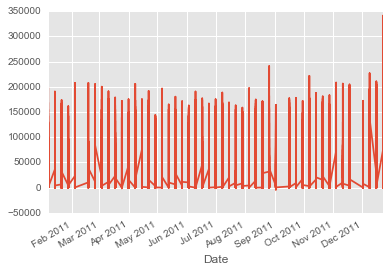

In [301]:
df[(df.IsHoliday == 0) & (df.Year == 2011)].Weekly_Sales.plot()

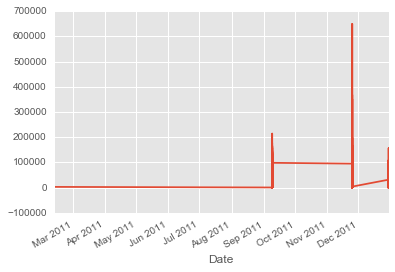

In [302]:
df[(df.IsHoliday == 1) & (df.Year == 2011)].Weekly_Sales.plot()

<strong><font size="6">Narrowing Down:</font></strong>

<strong>Let's choose the store that hosted the highest recorded sales out off 45 stores. (Store 10)</strong>

In [305]:
df = df[df.Store == 10][['Weekly_Sales']].resample('W').sum()
df.head()

,Weekly_Sales
Date,
2010-02-07,2193048.75
2010-02-14,2176028.52
2010-02-21,2113432.58
2010-02-28,2006774.96
2010-03-07,1987090.09


<strong>Let's see a graph of the rolling average weekly sales for store 10.</strong>

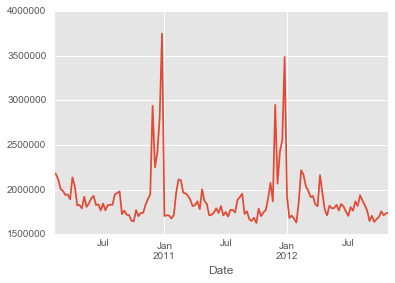

In [349]:
df.Weekly_Sales.rolling(window = 1).mean().plot()

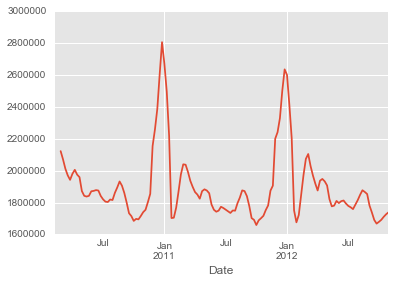

In [351]:
df.Weekly_Sales.rolling(window = 4).mean().plot()

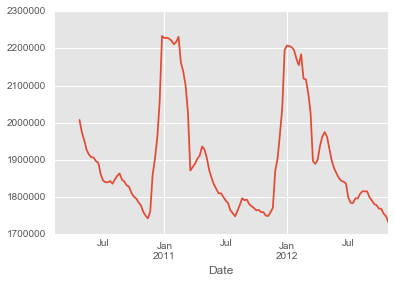

In [352]:
df.Weekly_Sales.rolling(window = 12).mean().plot()

<strong>So, the end of December up to January does a signiifcant level of volume, but we already knew that.</strong>

<strong>Let's see if there are any correlations between sales one week and the week prior, one month prior, and 3 months prior.</strong> 

In [312]:
print('Autocorrelation 1: ', df.Weekly_Sales.autocorr(1))
print('Autocorrelation 4: ', df.Weekly_Sales.autocorr(4))
print('Autocorrelation 12: ', df.Weekly_Sales.autocorr(12))

('Autocorrelation 1: ', 0.47942668111827863)
('Autocorrelation 4: ', 0.2215834704074921)
('Autocorrelation 12: ', -0.044842105200909289)


<strong>So far, sales the day before have the highest correlation to sales the next day.</strong> 

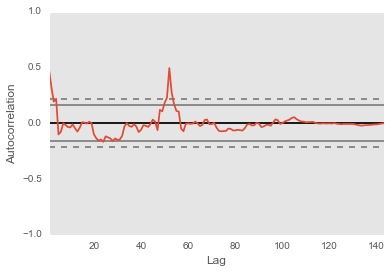

In [313]:
pd.tools.plotting.autocorrelation_plot(df.Weekly_Sales)

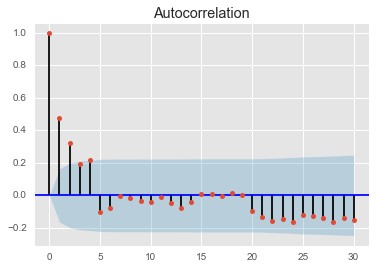

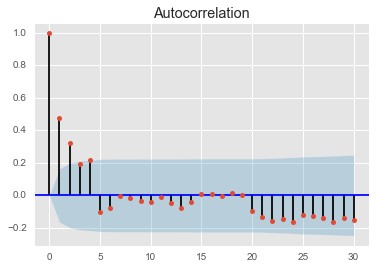

In [316]:

plot_acf(df.Weekly_Sales, lags = 30)

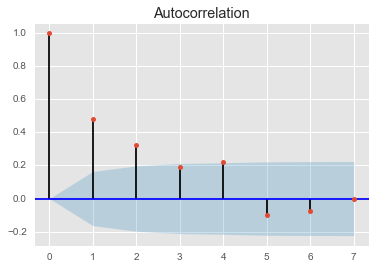

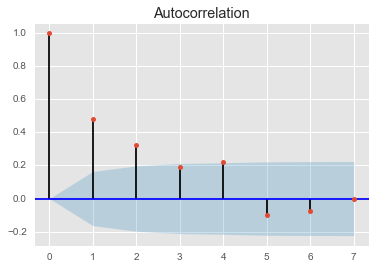

In [317]:

plot_acf(df.Weekly_Sales, lags = 7)

<strong><font size="9">Train and test</font></strong> 

In [338]:
n = len(df.Weekly_Sales)
m = int(.80 * n)

train = df.Weekly_Sales[:m]
test = df.Weekly_Sales[m:]

In [339]:
model = sm.tsa.arima_model.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic = False, 
    typ = 'levels'
)

print('Mean absolute error: ', metrics.mean_absolute_error(test, predictions))

model.summary()

AttributeError: 'module' object has no attribute 'arima_model'

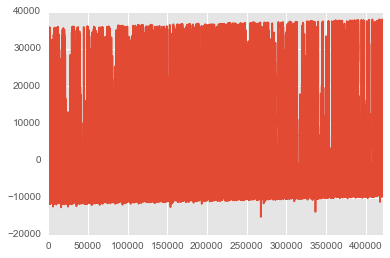

In [340]:
model.resid.plot()